# Inferring the number of components

* [Load modules](#load-modules)
* [Load data](#load-data)
* [Preprocess data](#preprocess-data)
* [Using `robustica.InferComponents` to choose the number of components for ICA](#run-robustica)

## Load modules <a class="anchor" id="load-modules"></a>

In [6]:
from robustica import InferComponents

import pandas as pd
import numpy as np
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns

## Load data from [Sastry (2019)](https://doi.org/10.1038/s41467-019-13483-w) <a class="anchor" id="load-data"></a>

In [3]:
url = "https://static-content.springer.com/esm/art%3A10.1038%2Fs41467-019-13483-w/MediaObjects/41467_2019_13483_MOESM4_ESM.xlsx"
data = pd.ExcelFile(url)
data.sheet_names

['README',
 'Metadata',
 'Expression Data',
 'S matrix',
 'A matrix',
 'Media Recipes',
 'Gene Information']

In [4]:
data.parse("README")

,Sheet Name,Description
0,Experimental Conditions,Experimental conditions for each sample in PRE...
1,Expression Data,Expression levels of genes (log2 Transcripts p...
2,S matrix,I-modulon gene coefficients. Each column is an...
3,A matrix,Condition-specific i-modulon activities. Each ...
4,Media Description,Recipes for base media and trace element mixtures
5,Gene Information,Mapping of b-numbers to gene names/annotations...
6,NaN,NaN
7,Metadata Columns,Description
8,Sample ID,Unique sample identifier for experiment (e.g. ...
9,Study,Short 1-2 word description of study where samp...


## Preprocess data <a class="anchor" id="preprocess-data"></a>
Following the article's methods, we compute the log2FCs with respect to controls

In [5]:
# get gene expression
X = data.parse("Expression Data").set_index("log-TPM")

# get controls
controls = [c for c in X.columns if "control" in c]
print(controls)

# compute log2FCs with respect to controls
X = X - X[controls].mean(1).values.reshape(-1, 1)

X

['control__wt_glc__1', 'control__wt_glc__2']


,control__wt_glc__1,control__wt_glc__2,fur__wt_dpd__1,fur__wt_dpd__2,fur__wt_fe__1,fur__wt_fe__2,fur__delfur_dpd__1,fur__delfur_dpd__2,fur__delfur_fe2__1,fur__delfur_fe2__2,acid__wt_ph5__1,acid__wt_ph5__2,acid__delgadx_ph5__1,acid__delgadx_ph5__2,acid__delgadw_ph5__1,acid__delgadw_ph5__2,acid__delgade_ph5__1,acid__delgade_ph5__2,oxidative__wt_pq__1,oxidative__wt_pq__2,oxidative__deloxyr_pq__1,oxidative__deloxyr_pq__2,oxidative__delsoxr_pq__1,oxidative__delsoxr_pq__2,oxidative__delsoxs_pq__1,oxidative__delsoxs_pq__2,nac_ntrc__wt_csn__1,nac_ntrc__wt_csn__2,nac_ntrc__wt_cytd__1,nac_ntrc__wt_cytd__2,nac_ntrc__wt_gln__1,nac_ntrc__wt_gln__2,nac_ntrc__bw_delnac_csn__1,nac_ntrc__bw_delnac_csn__2,nac_ntrc__bw_delnac_cytd__1,nac_ntrc__bw_delnac_cytd__2,nac_ntrc__bw_delnac_gln__1,nac_ntrc__bw_delnac_gln__2,nac_ntrc__bw_delnac_nh4__1,nac_ntrc__bw_delnac_nh4__2,...,fps__fps_ptsI_ale3__1,fps__fps_ptsI_ale3__2,pal__lyx_ale2_f6__1,pal__lyx_ale2__1,pal__lyx_ale2__2,pal__lyx_ale4__1,pal__lyx_ale4__2,pal__5drib_ale10_f18__1,pal__5drib_ale10_f18__2,pal__5drib_ale10__1,pal__arab_ale14_f9__1,pal__arab_ale14_f9__2,pal__arab_ale14__1,pal__arab_ale14__2,pal__arab_ale16__1,pal__arab_ale16__2,pal__tartr_ale26_f10__1,pal__tartr_ale26_f10__2,pal__tartr_ale26__1,pal__tartr_ale26__2,pal__tartr_ale28_f10__1,pal__tartr_ale28_f10__2,pal__tartr_ale28__1,pal__tartr_ale28__2,efeU__delmenFentC_citr__1,efeU__delmenFentC_citr__2,efeU__delmenFentC__1,efeU__delmenFentC__2,efeU__menFentC_ale39__1,efeU__menFentC_ale39__2,efeU__menFentC_ale29__1,efeU__menFentC_ale29__2,efeU__menFentC_ale30__1,efeU__menFentC_ale30__2,efeU__menFentCubiC_ale36__1,efeU__menFentCubiC_ale36__2,efeU__menFentCubiC_ale37__1,efeU__menFentCubiC_ale37__2,efeU__menFentCubiC_ale38__1,efeU__menFentCubiC_ale38__2
log-TPM,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
b0002,-0.061772,0.061772,0.636527,0.819793,-0.003615,-0.289353,-1.092023,-0.777289,0.161343,0.145641,-0.119071,-0.110208,-0.119834,-0.249929,-0.170032,-0.157507,0.056637,0.126969,-3.100216,-3.131342,-2.023795,-2.149554,-2.984711,-2.969394,-3.275657,-3.194996,0.089418,0.125114,-1.018795,-1.027832,-0.847223,-0.783328,0.281646,0.314592,-0.140874,-0.127610,-0.767873,-0.795065,0.450165,0.465124,...,-1.002889,-1.041576,-1.441137,-0.938109,-0.912962,-0.938109,-0.912962,-3.117297,-3.060093,-2.635028,-0.921975,-0.759323,-0.541732,-0.585120,-2.023105,-2.172182,-2.744032,-3.578483,-2.439898,-2.158964,-2.842505,-3.817478,-2.774715,-3.092458,0.173153,0.251183,-0.578962,-0.434636,-0.592134,-0.856110,-0.797097,-0.791859,0.080114,0.102154,0.608180,0.657673,0.813105,0.854813,0.427986,0.484338
b0003,-0.053742,0.053742,0.954439,1.334385,0.307588,0.128414,-0.872563,-0.277893,0.428542,0.391761,0.287202,0.362728,0.307697,0.400402,0.309537,0.260044,0.418749,0.494192,-2.270702,-2.250099,-1.469153,-1.422126,-2.079466,-2.186045,-2.088128,-2.153957,-0.010339,0.071343,-0.856189,-0.959230,-0.804255,-0.717709,0.176045,0.513432,-0.083092,-0.029230,-0.655933,-0.680968,0.490329,0.568717,...,-0.904180,-0.847871,-1.218862,-0.760452,-0.638258,-0.760452,-0.638258,-2.531969,-2.353000,-2.170580,-0.723489,-0.598414,-0.451662,-0.435296,-1.915111,-1.894400,-2.193731,-2.692549,-1.954520,-1.774417,-2.448988,-2.825048,-2.442953,-2.509852,0.045521,0.153003,-0.823835,-0.766693,-0.114129,-0.293120,-0.309105,-0.352535,-0.155074,-0.077145,0.447030,0.439881,0.554528,0.569030,0.154905,0.294799
b0004,-0.065095,0.065095,-0.202697,0.119195,-0.264995,-0.546017,-1.918349,-1.577736,-0.474815,-0.495312,-0.377931,-0.455821,-0.419130,-0.403719,-0.530110,-0.438404,-0.251625,-0.273382,-3.035159,-2.936996,-2.059695,-2.067639,-2.900563,-2.992547,-3.000908,-2.978825,-0.386857,-0.283963,-1.127038,-1.037145,-1.067582,-0.949621,-0.392185,-0.507103,-0.350306,-0.375661,-0.864982,-0.942486,0.351071,0.326690,...,-0.738546,-0.695458,-1.456153,-0.610523,-0.469339,-0.610523,-0.469339,-2.692792,-2.634547,-2.109905,-0.829474,-0.782205,-0.367654,-0.359077,-1.706871,-1.861162,-2.310515

## Using PCA to select the number of components for ICA <a class="anchor" id="run-robustica"></a>

By default, the [*FastICA*](https://doi.org/10.1109/NNSP.2003.1318025) algorithm whitens the data before calculating independent components to accelerate convergence. In other words, it performs PCA to compress the data into the number of components that we desire. Hence, PCA can be very helpful at guessing the number of components that we aim for.

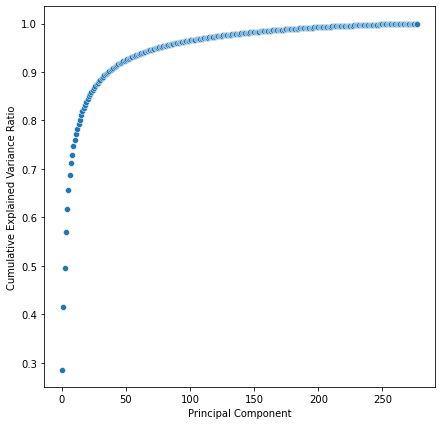

In [9]:
# how many components explain a % of variance
pca = PCA()
pca.fit(X)

plt.figure(figsize=(7, 7))
sns.scatterplot(
    x=np.arange(pca.n_components_), y=np.cumsum(pca.explained_variance_ratio_)
)
plt.xlabel("Principal Component")
plt.ylabel("Cumulative Explained Variance Ratio")

plt.show()

In this case, we would only need less than 50 components to explain 90% of the variance of the dataset.

To do exactly this in a single call -i.e. getting the number of components that explain a certain % of the variance- we can use `robustica.InferComponents`.

In [12]:
InferComponents(0.9).fit_predict(X)

36